<a href="https://colab.research.google.com/github/proffix4/BQ_RST/blob/master/%D0%A1%D0%B5%D1%80%D0%B3%D0%B5%D0%B9_%D0%A2%D0%B0%D0%BB%D0%B8%D0%BF%D0%BE%D0%B2_Project_CNN_Age_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: CNN для классификации лиц по возрасту

## Подготовка окружения

In [ ]:
# # Установка / обновление необходимых библиотек
# !pip install -q --upgrade torch torchvision timm albumentations opencv-python-headless scikit-learn torchsummary tqdm pandas matplotlib
# !pip install -q imagehash pillow
# !pip install seaborn

## Импорт и базовые настройки

In [ ]:
# Импорт
import os, zipfile, random, json, shutil, math, time
from pathlib import Path

import torch, torchvision
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchsummary import summary
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import imagehash

import hashlib, collections, itertools
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

# Девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)


Using: cpu


## Скачивание и распаковка данных

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Скачивание и распаковка data.zip (для локального ПК, без Google Colab)
# ─────────────────────────────────────────────────────────────────────────────
import subprocess, sys, zipfile
from pathlib import Path

# 1. URL архива на Google Drive
DATA_ZIP_URL = "https://drive.google.com/uc?id=1ExAQWzA1IkRus0OBiNNj08yO_wzc35B5"
zip_path = Path("data.zip")

# 2. gdown: гарантируем, что установлен
try:
    import gdown
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gdown"])
    import gdown

# 3. скачиваем, если ещё нет
if not zip_path.exists():
    print("Скачиваю data.zip …")
    gdown.download(DATA_ZIP_URL, str(zip_path), quiet=False)
else:
    print("data.zip уже существует — пропускаю скачивание.")

# 4. распаковка
print("Распаковываю …")
with zipfile.ZipFile(zip_path, "r") as zf:
    zf.extractall("data")

# 5. быстрая проверка
data_root = Path("data")
print("train samples:", len(list((data_root / "train").glob("*"))))
print("test  samples:", len(list((data_root / "test").glob("*"))))


data.zip уже существует — пропускаю скачивание.
Распаковываю …
train samples: 10099
test  samples: 102


## Разведочный анализ (EDA)

In [ ]:
# Задаём папки для теста и обучения
train_dir = data_root / 'train'
test_dir  = data_root / 'test'

In [ ]:
# -- 1. Сканируем изображения и собираем информацию
def collect_meta(folder: Path):
    records = []
    for img_path in tqdm(list(folder.glob('*.jpg')), desc=f'Scanning {folder.name}'):
        try:
            label = int(img_path.stem.split('_')[0])      # метка = число до "_"
            img = cv2.imread(str(img_path))
            h, w = img.shape[:2]
            records.append({
                'split' : folder.name,
                'path'  : str(img_path),
                'label' : label,
                'width' : w,
                'height': h,
            })
        except Exception as e:
            print('⚠️', img_path, e)
    return records

meta_records = collect_meta(train_dir) + collect_meta(test_dir)
df_meta = pd.DataFrame(meta_records)
print('DataFrame shape:', df_meta.shape)
df_meta.head()

Scanning train:   0%|          | 0/10098 [00:00<?, ?it/s]

⚠️ data\train\0nan_5555.jpg invalid literal for int() with base 10: '0nan'


Scanning test:   0%|          | 0/102 [00:00<?, ?it/s]

DataFrame shape: (10199, 5)


,split,path,label,width,height
0,train,data\train\0_1001.jpg,0,200,200
1,train,data\train\0_1005.jpg,0,200,200
2,train,data\train\0_1019.jpg,0,200,200
3,train,data\train\0_1022.jpg,0,200,200
4,train,data\train\0_1024.jpg,0,200,200


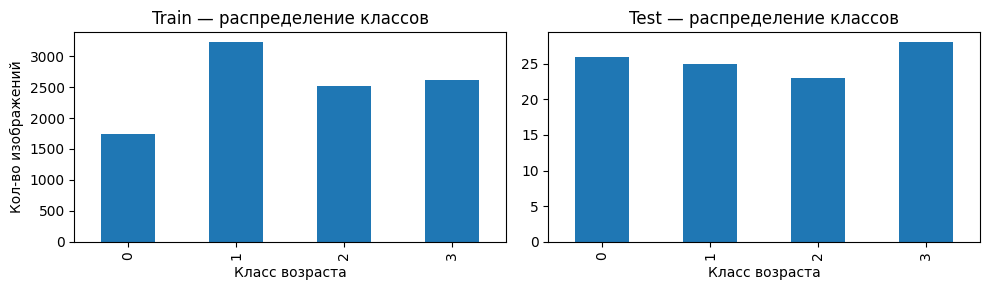

In [ ]:
# -- 2. Баланс классов (train / test)
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

(df_meta[df_meta.split == 'train'].label
       .value_counts()
       .sort_index()
       .plot(kind='bar', ax=axes[0], title='Train — распределение классов'))
axes[0].set_xlabel('Класс возраста')
axes[0].set_ylabel('Кол-во изображений')

(df_meta[df_meta.split == 'test'].label
       .value_counts()
       .sort_index()
       .plot(kind='bar', ax=axes[1], title='Test — распределение классов'))
axes[1].set_xlabel('Класс возраста')

plt.tight_layout(); plt.show()

In [ ]:
# -- 2. Баланс классов (train / test)
print('\nTrain summary:')
print(df_meta[df_meta.split == 'train'].groupby('label').size())

print('\nTest summary:')
print(df_meta[df_meta.split == 'test'].groupby('label').size())



Train summary:
label
0    1743
1    3223
2    2521
3    2610
dtype: int64

Test summary:
label
0    26
1    25
2    23
3    28
dtype: int64


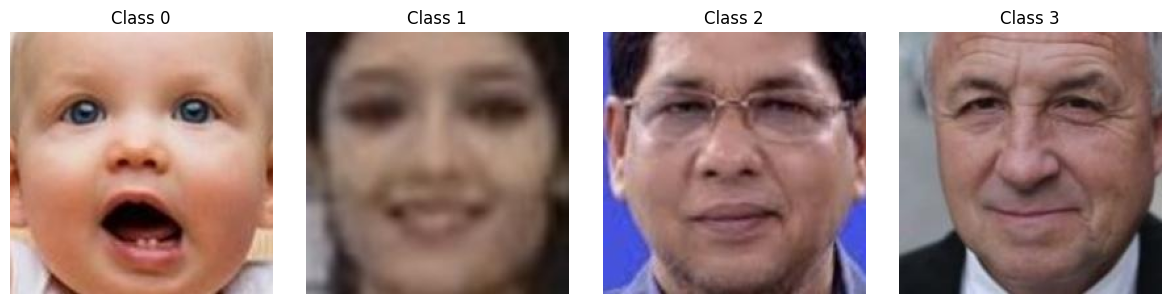

In [ ]:
# -- 3. Визуальная проверка: по одному примеру каждого класса
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for cls in range(4):
    sample_path = random.choice(
        df_meta[(df_meta.label == cls) & (df_meta.split == 'train')].path.values
    )
    img = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)
    axes[cls].imshow(img)
    axes[cls].set_title(f'Class {cls}')
    axes[cls].axis('off')
plt.tight_layout(); plt.show()


In [ ]:
# ▶️ Найти изображения не 200×200
non_200 = df_meta[(df_meta.width != 200) | (df_meta.height != 200)]
print(f'Всего изображений ≠ 200×200: {len(non_200)}')
display(non_200.head())


Всего изображений ≠ 200×200: 100


,split,path,label,width,height
4966,train,data\train\2_10007.jpg,2,202,244
4967,train,data\train\2_10008.jpg,2,455,471
4968,train,data\train\2_10009.jpg,2,363,303
4969,train,data\train\2_10011.jpg,2,565,410
4970,train,data\train\2_10012.jpg,2,280,531


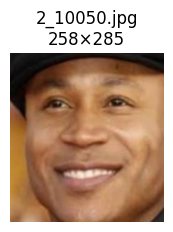

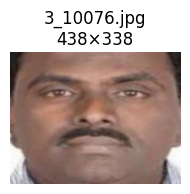

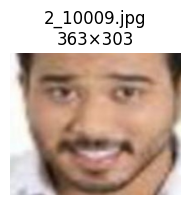

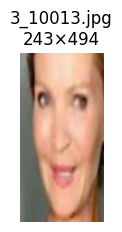

In [ ]:
# ▶️ 4 случайных примера
sample_paths = non_200.sample(min(4, len(non_200)), random_state=0).path.tolist()

for p in sample_paths:
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2.2,2.2))
    plt.imshow(img)
    plt.title(f'{Path(p).name}\n{img.shape[1]}×{img.shape[0]}')
    plt.axis('off')
    plt.show()

## Обработка и фильтрация названии и разммеров

In [ ]:
# ▶️ Удаляем файлы с некорректными названиями
from pathlib import Path

bad_files = [
    Path('data/train/0nan_5555.jpg'),
    Path('data/test/0???.jpg'),
]

for f in bad_files:
    if f.exists():
        f.unlink()      # удаляем файл
        print('Deleted:', f)
    else:
        print('Not found (already deleted?):', f)


Deleted: data\train\0nan_5555.jpg
Not found (already deleted?): data\test\0???.jpg


In [ ]:
# Обрабатываем файлы с некорректными разрешением
# non_200 уже содержит пути «нестандартных» файлов
for img_path in tqdm(non_200.path, desc='Resizing to 200×200'):
    img = cv2.imread(img_path)
    if img is None:
        print('⚠️ Не удалось прочитать', img_path)
        continue
    h, w = img.shape[:2]
    # если картинка меньше 200 px, INTER_CUBIC; если больше — INTER_AREA
    interp = cv2.INTER_CUBIC if (h < 200 or w < 200) else cv2.INTER_AREA
    img_resized = cv2.resize(img, (200, 200), interpolation=interp)
    cv2.imwrite(img_path, img_resized)

print('Готово! Все файлы приведены к 200×200.')

Resizing to 200×200:   0%|          | 0/100 [00:00<?, ?it/s]

Готово! Все файлы приведены к 200×200.


In [ ]:
# ▶️ Перепроверка размеров после ресайза
df_check = pd.DataFrame(
    collect_meta(train_dir) + collect_meta(test_dir)   # функция collect_meta уже объявлена
)

leftovers = df_check[(df_check.width != 200) | (df_check.height != 200)]
print(f'Файлов ≠ 200×200 после обработки: {len(leftovers)}')

if len(leftovers) == 0:
    print('✅ Все изображения теперь 200×200 px')
else:
    display(leftovers.head())        # покажем первые «проблемные» (если вдруг есть)

Scanning train:   0%|          | 0/10097 [00:00<?, ?it/s]

Scanning test:   0%|          | 0/102 [00:00<?, ?it/s]

Файлов ≠ 200×200 после обработки: 0
✅ Все изображения теперь 200×200 px


## Изучение изображении

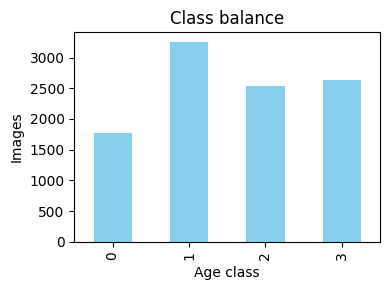

⏳ Вычисляю хэши для поиска дубликатов…


hashing:   0%|          | 0/10199 [00:00<?, ?it/s]

▪ MD5-дубликатов групп:   77
▪ aHash-дубликатов групп: 250
⏳ Определяю цвет/ч/б…


modality:   0%|          | 0/10199 [00:00<?, ?it/s]

▪ Grayscale изображений : 268
▪ Цветных изображений   : 9931
⏳ Анализирую яркость…


brightness:   0%|          | 0/10199 [00:00<?, ?it/s]

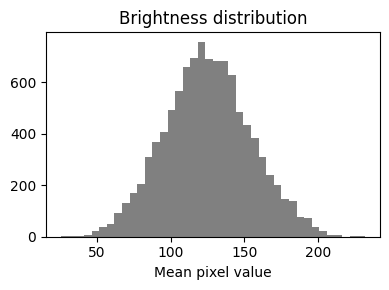

▪ Слишком тёмных/ярких кадров: 0
⏳ Оцениваю резкость…


laplacian:   0%|          | 0/10199 [00:00<?, ?it/s]

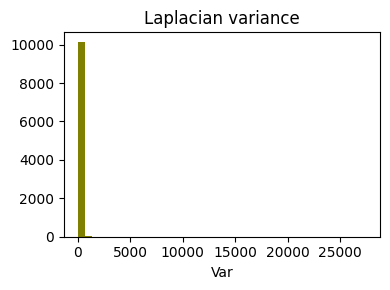

▪ Размытых (var < 50): 6819
✓ Проверки завершены — при наличии проблем файлы списков сохранены.


In [ ]:
# 1. Баланс классов ───────────────────────────────────────────────────────────
plt.figure(figsize=(4,3))
(df_check.label.value_counts().sort_index()
   .plot(kind='bar', color='skyblue', title='Class balance'))
plt.xlabel('Age class'); plt.ylabel('Images'); plt.tight_layout(); plt.show()

# 2. Дубликаты по MD5 и aHash ────────────────────────────────────────────────
print('⏳ Вычисляю хэши для поиска дубликатов…')
md5_map, ahash_map = collections.defaultdict(list), collections.defaultdict(list)

for p in tqdm(df_check.path, desc='hashing'):
    with open(p, 'rb') as f:
        md5_map[hashlib.md5(f.read()).hexdigest()].append(p)
    ahash_map[str(imagehash.average_hash(Image.open(p)))].append(p)

dup_md5   = [v for v in md5_map.values()   if len(v) > 1]
dup_ahash = [v for v in ahash_map.values() if len(v) > 1]

print(f'▪ MD5-дубликатов групп:   {len(dup_md5)}')
print(f'▪ aHash-дубликатов групп: {len(dup_ahash)}')

# 3. Модальность: RGB vs grayscale ───────────────────────────────────────────
print('⏳ Определяю цвет/ч/б…')
is_gray = []
for p in tqdm(df_check.path, desc='modality'):
    img = cv2.imread(p)
    gray_flag = np.all(img[...,0] == img[...,1]) and np.all(img[...,1] == img[...,2])
    is_gray.append(gray_flag)

df_check['is_gray'] = is_gray
print(f'▪ Grayscale изображений : {df_check.is_gray.sum()}')
print(f'▪ Цветных изображений   : {len(df_check) - df_check.is_gray.sum()}')

# 4. Яркость: поиск тёмных/пересвеченных ─────────────────────────────────────
print('⏳ Анализирую яркость…')
brightness = []
for p in tqdm(df_check.path, desc='brightness'):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    brightness.append(img.mean())

df_check['brightness'] = brightness
plt.figure(figsize=(4,3))
plt.hist(df_check['brightness'], bins=40, color='gray')
plt.title('Brightness distribution'); plt.xlabel('Mean pixel value')
plt.tight_layout(); plt.show()

extreme = df_check[(df_check.brightness < 20) | (df_check.brightness > 235)]
print(f'▪ Слишком тёмных/ярких кадров: {len(extreme)}')

# 5. Размытость: variance of Laplacian ───────────────────────────────────────
print('⏳ Оцениваю резкость…')
lap_vars = []
for p in tqdm(df_check.path, desc='laplacian'):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    lap_vars.append(cv2.Laplacian(img, cv2.CV_64F).var())

df_check['lap_var'] = lap_vars
plt.figure(figsize=(4,3))
plt.hist(df_check['lap_var'], bins=40, color='olive')
plt.title('Laplacian variance'); plt.xlabel('Var'); plt.tight_layout(); plt.show()

blur_thresh = 50
blurry = df_check[df_check.lap_var < blur_thresh]
print(f'▪ Размытых (var < {blur_thresh}): {len(blurry)}')

# (опц.) сохранить проблемные списки
pd.Series(itertools.chain(*dup_md5)).to_csv('duplicate_md5.txt',   index=False, header=False)
pd.Series(itertools.chain(*dup_ahash)).to_csv('duplicate_ahash.txt', index=False, header=False)
extreme.path.to_csv('extreme_brightness.txt', index=False, header=False)
blurry.path.to_csv('blurry_images.txt',       index=False, header=False)

print('✓ Проверки завершены — при наличии проблем файлы списков сохранены.')

Всего grayscale изображений: 268


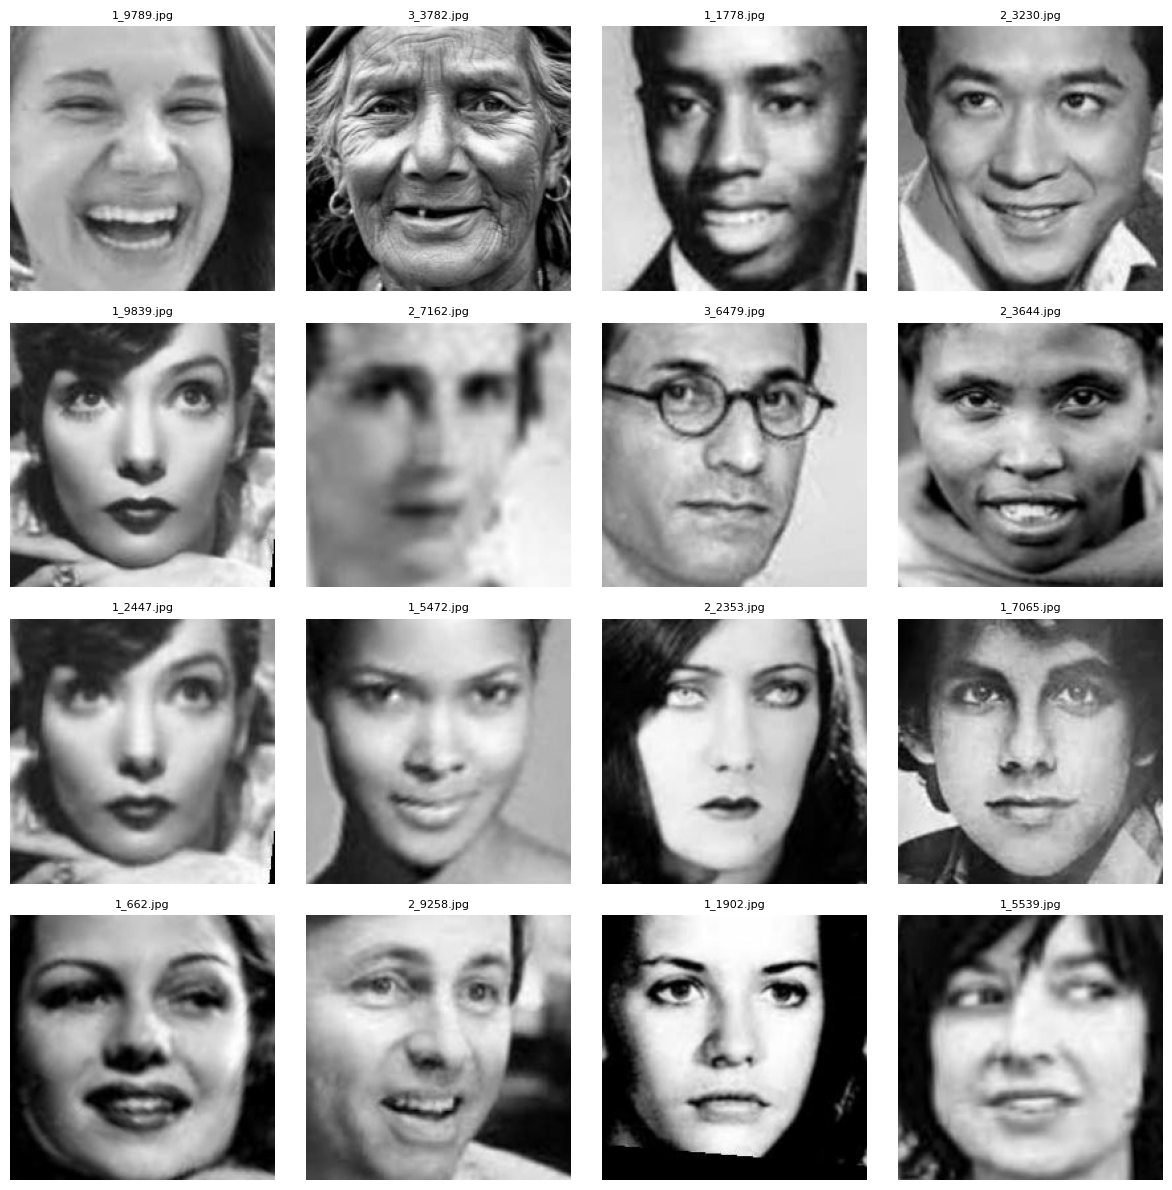

In [ ]:
# ▶️ Визуализация ч/б (grayscale) изображений
# df_check уже содержит столбец is_gray, созданный на предыдущем шаге
gray_df = df_check[df_check.is_gray]
print(f'Всего grayscale изображений: {len(gray_df)}')

# Параметры отображения
sample_n = min(16, len(gray_df))          # покажем максимум 16 штук
cols, rows = 4, math.ceil(sample_n / 4)

sample_paths = gray_df.sample(sample_n, random_state=42).path.tolist()

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
axes = axes.flatten()

for ax, p in zip(axes, sample_paths):
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)    # читаем как 1-канальное
    ax.imshow(img, cmap='gray')
    ax.set_title(Path(p).name, fontsize=8)
    ax.axis('off')

# скрываем лишние ячейки, если sample_n < rows*cols
for ax in axes[len(sample_paths):]:
    ax.axis('off')

plt.tight_layout(); plt.show()


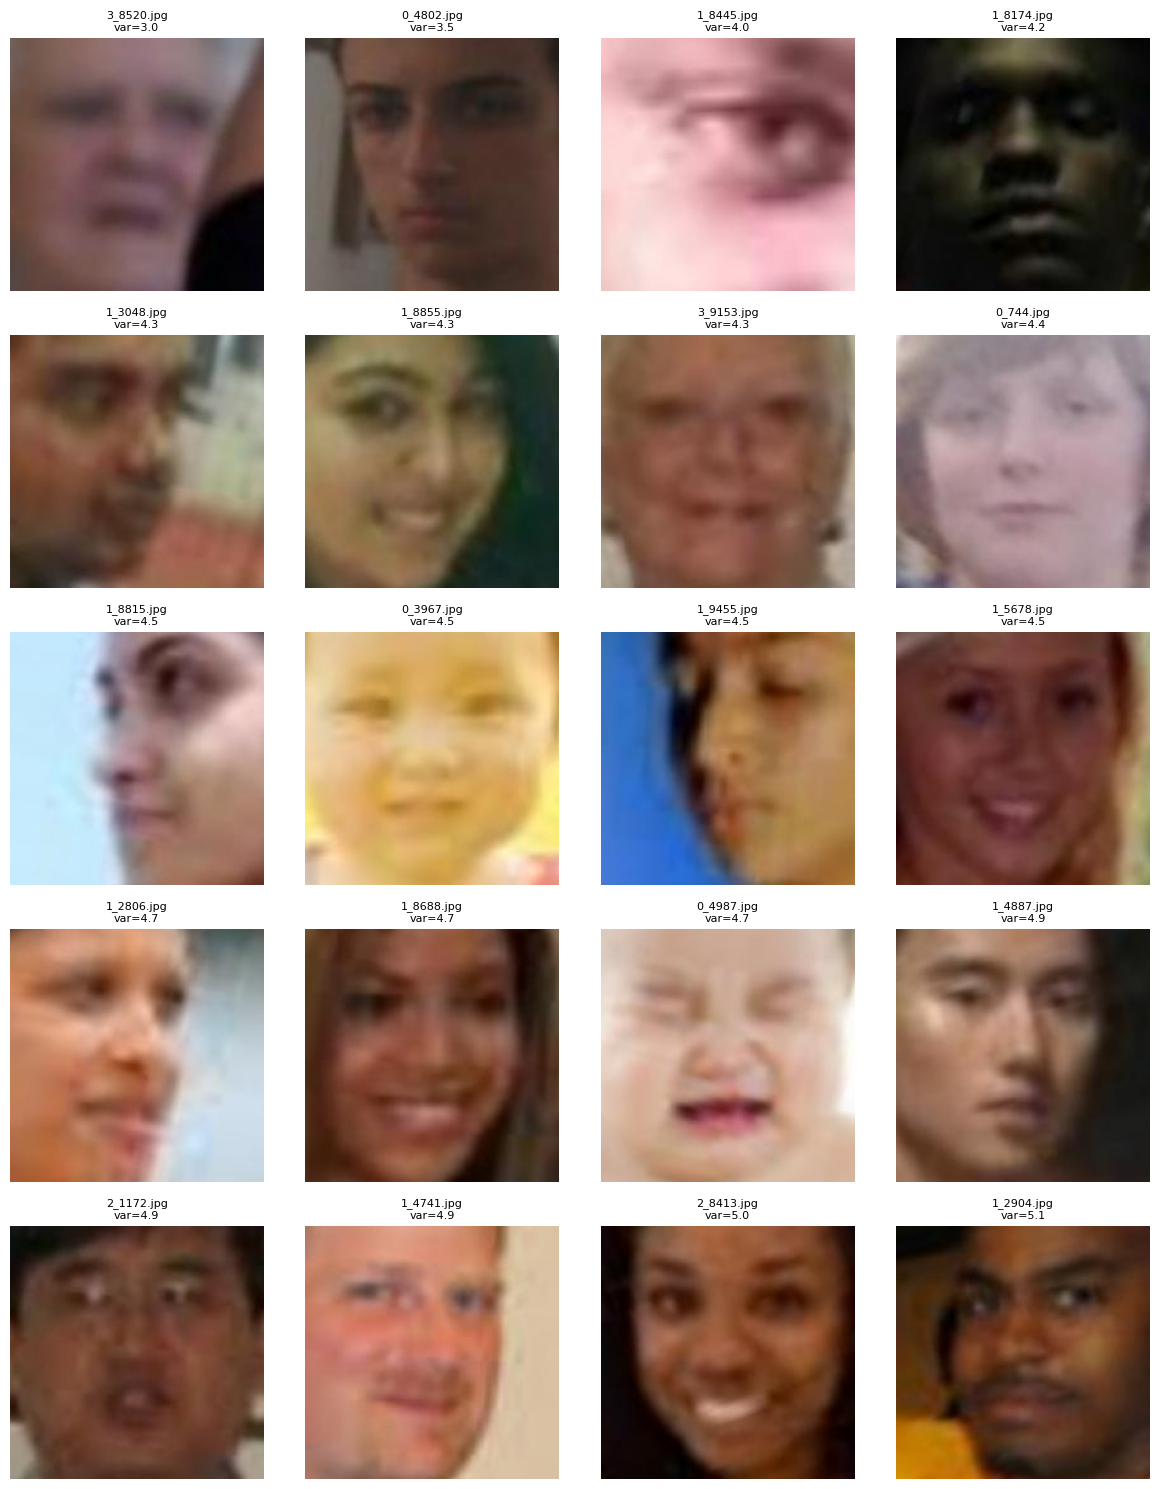

In [ ]:
# ▶️ Визуализация самых «мыльных» (variance-of-Laplacian минимальна)
# убедимся, что столбец lap_var существует
assert 'lap_var' in df_check.columns, "Сначала вычислите df_check['lap_var'] (variance of Laplacian)"

k = 20                          # сколько самых размытых показать
top_blur = df_check.sort_values('lap_var').head(k)

rows, cols = math.ceil(k / 4), 4
fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
axes = axes.flatten()

for ax, (_, row) in zip(axes, top_blur.iterrows()):
    img = cv2.cvtColor(cv2.imread(row.path), cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(f"{Path(row.path).name}\nvar={row.lap_var:.1f}", fontsize=8)
    ax.axis('off')

# скрываем лишние ячейки, если k не кратно 4
for ax in axes[len(top_blur):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Обработка дубликатов и корректировка цветов

In [ ]:
#  1. Дубликаты  ──────────────────────────────────────────────────────────────
# собираем единый список «лишних» файлов (оставляем первый экземпляр)
dups_to_delete = set()

for group in dup_md5 + dup_ahash:
    group_sorted = sorted(group)                # фиксируем порядок
    dups_to_delete.update(group_sorted[1:])     # всё, кроме первого в группе

print(f'Удаляем {len(dups_to_delete)} файлов-дубликатов …')

deleted_on_disk = []                            # чтобы потом вычистить df_check
for p in dups_to_delete:
    fp = Path(p)
    if fp.exists():                             # удаляем прямо из папки
        try:
            fp.unlink()                         # == os.remove(fp)
            deleted_on_disk.append(p)
        except Exception as e:
            print('⚠️', p, e)

# синхронизируем df_check: убираем строки с реально удалёнными файлами
before = len(df_check)
df_check = df_check[~df_check.path.isin(deleted_on_disk)].reset_index(drop=True)
after  = len(df_check)

print(f'✔ Удалено с диска: {len(deleted_on_disk)}')
print(f'Обновлён df_check: {before} → {after} записей')


Удаляем 267 файлов-дубликатов …
✔ Удалено с диска: 267
Обновлён df_check: 10199 → 9932 записей


Почти все пред-обученные модели из torchvision/timm (ResNet-50, EfficientNet, ViT и т. д.) принимают тензоры формы [B, 3, H, W]. Одноканальное изображение ([B, 1, H, W]) вызовет ошибку shapes mismatch.

In [ ]:
#  2. Grayscale → 3-канальный RGB
gray_paths = df_check[df_check.is_gray].path.tolist()
print(f'Конвертирую {len(gray_paths)} ч/б изображений в 3-канальный формат…')

for p in gray_paths:
    img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)         # shape (H,W)
    if img is None:
        print('⚠️ Не прочитан', p); continue
    rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)       # 3-канальный
    cv2.imwrite(p, rgb)

Конвертирую 266 ч/б изображений в 3-канальный формат…


In [ ]:
# 3. Удаляем 100 самых «мыльных» (с минимальной lap_var)
assert 'lap_var' in df_check.columns, "сначала вычислите df_check['lap_var']"

n_remove   = 100
top_blur   = df_check.sort_values('lap_var').head(n_remove)
trash_dir  = Path('discarded_top_blurry')
trash_dir.mkdir(exist_ok=True)

moved = 0
for p in top_blur.path:
    src = Path(p)
    if src.exists():                      # перемещаем только существующие
        shutil.move(src, trash_dir / src.name)
        moved += 1

# удаляем строки о реально перемещённых файлах
df_check = df_check[~df_check.path.isin(top_blur.path[top_blur.path.apply(lambda s: Path(s).exists() is False)])]
df_check.reset_index(drop=True, inplace=True)

print(f'✔ Перемещено {moved} файлов → {trash_dir}/')
print('Осталось изображений в выборке:', len(df_check))


✔ Перемещено 100 файлов → discarded_top_blurry/
Осталось изображений в выборке: 9832


# 3. Предобработка и аугментации

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 0) Итоговый датафрейм
# ─────────────────────────────────────────────────────────────────────────────
df_clean = df_check.copy().reset_index(drop=True)   # ←  финальный набор
print('df_clean:', df_clean.shape)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Стратифицированный сплит 70 / 15 / 15
# ─────────────────────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split

# убираем колонку split (train/test), оставляя путь и метку
df_all = df_clean.drop(columns=['split'])
print('Всего изображений для сплита:', len(df_all))

train_df, temp_df = train_test_split(
    df_all, test_size=0.30, stratify=df_all.label, random_state=42)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, stratify=temp_df.label, random_state=42)

print(f'Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}')


df_clean: (9832, 8)
Всего изображений для сплита: 9832
Train: 6882 | Val: 1475 | Test: 1475


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 2) Transforms / Dataset / DataLoader  (чистый torchvision, безопасно для Windows)
# ─────────────────────────────────────────────────────────────────────────────
from torchvision import transforms
from PIL import Image
import torch, numpy as np
from torch.utils.data import DataLoader

# ── 1. Аугментации torchvision ──────────────────────────────────────────────
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
    # аналог CoarseDropout: выполняется ПОСЛЕ Normalize на тензоре
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.10), ratio=(0.3, 3.3),
                             value='random')
])

val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

# ── 2. Dataset на PIL-Image ─────────────────────────────────────────────────
class AgeDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform):
        self.paths   = df.path.values
        self.labels  = df.label.values.astype(np.int64)
        self.transform = transform

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")   # читаем через PIL
        img = self.transform(img)
        return img, self.labels[idx]

# ── 3. DataLoader-ы ─────────────────────────────────────────────────────────
# На Windows в Jupyter/VS Code безопаснее num_workers=0 (иначе возможен dead-lock)
NUM_WORKERS = 0          # поменяйте на >0, если запускаете в Linux или .py-скрипте
PIN_MEMORY  = False      # pin_memory=True полезно, только если есть CUDA-GPU

batch_size = 32
train_loader = DataLoader(AgeDataset(train_df, train_transforms),
                          batch_size=batch_size, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

val_loader   = DataLoader(AgeDataset(val_df,   val_transforms),
                          batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

test_loader  = DataLoader(AgeDataset(test_df,  val_transforms),
                          batch_size=batch_size, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print('✅ DataLoader-ы готовы (torchvision only). Переходим к шагу 4.')


✅ DataLoader-ы готовы (torchvision only). Переходим к шагу 4.


# 4. Модель и стратегия обучения

В классическом ResNet-50, который приходит из torchvision.models.resnet50 (или timm resnet50), принято считать “слоём” только операции с обучаемыми параметрами:
ИТОГО обучаемых слоёв	50

    49 сверточных + 1 fully-connected = ResNet-50.

BatchNorm, ReLU, MaxPool и AdaptiveAvgPool к «слоям» не приписывают, иначе общее число модулей в summary() будет ~177.

После «reset fc» мы заменяем только последний слой (fc) на форму 2048 → 4; остальные 49 conv-слоёв остаются с ImageNet-весами (заморожены в warm-up, размораживаются при fine-tune).

### Визуализация блоков Resnet-50

In [ ]:
from torchvision import models
from torchsummary import summary     # уже установлен ранее
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── 1. Загружаем пред-обученную сеть и смотрим "до" ─────────────────────────
model_before = models.resnet50(weights="IMAGENET1K_V2").to(device)

print('*** BEFORE ***')
print(model_before.fc)               # только классификатор
summary(model_before, (3, 224, 224)) # сводка всего графа

# ── 2. Заменяем финальный FC-слой на 4 выхода ───────────────────────────────
in_features = model_before.fc.in_features        # 2048
model_before.fc = torch.nn.Linear(in_features, 4)
model_after = model_before                      # просто для читаемости

print('\n*** AFTER ***')
print(model_after.fc)
summary(model_after, (3, 224, 224))


*** BEFORE ***
Linear(in_features=2048, out_features=1000, bias=True)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1

In [ ]:
for child in model_after.named_children():
  print(child[0]) #(child)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


  step 100/216  loss 1.118
  step 200/216  loss 1.211
E01/15 | TR 1.2416/0.445 | VA 1.1427/0.539 | lr 3.0e-04
  ↳ new best saved
  step 100/216  loss 1.060
  step 200/216  loss 1.143
E02/15 | TR 1.1151/0.529 | VA 1.0586/0.565 | lr 3.0e-04
  ↳ new best saved
  step 100/216  loss 1.092
  step 200/216  loss 1.225
E03/15 | TR 1.0695/0.545 | VA 1.0335/0.573 | lr 3.0e-04
  ↳ new best saved
  step 100/216  loss 0.785
  step 200/216  loss 0.797
E04/15 | TR 0.8686/0.624 | VA 0.7108/0.692 | lr 9.8e-05
  ↳ new best saved
  step 100/216  loss 0.637
  step 200/216  loss 0.503
E05/15 | TR 0.7280/0.677 | VA 0.6690/0.699 | lr 9.3e-05
  ↳ new best saved
  step 100/216  loss 0.629
  step 200/216  loss 0.675
E06/15 | TR 0.6347/0.726 | VA 0.6486/0.706 | lr 8.5e-05
  ↳ new best saved
  step 100/216  loss 0.638
  step 200/216  loss 0.517
E07/15 | TR 0.5870/0.747 | VA 0.6051/0.734 | lr 7.5e-05
  ↳ new best saved
  step 100/216  loss 0.465
  step 200/216  loss 0.620
E08/15 | TR 0.5298/0.773 | VA 0.7136/0.698 

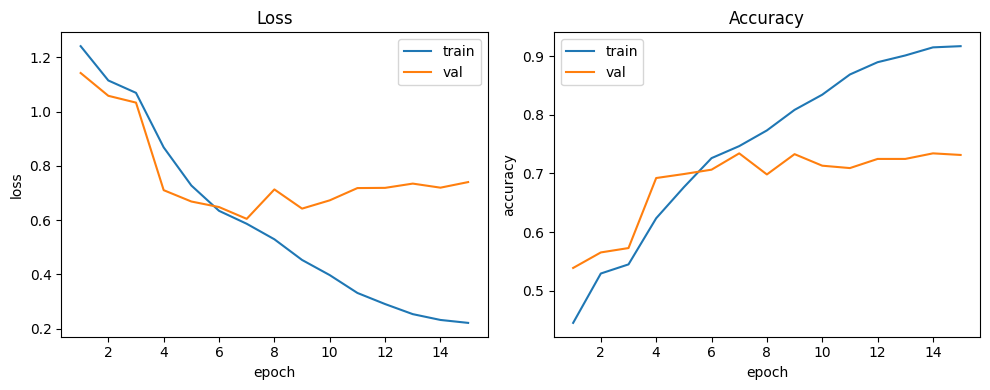

График сохранён в curves.png; логи в train_log.jsonl


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 4) Модель + полная стратегия обучения:
#    • warm-up + fine-tune
#    • много чек-пойнтов  (last, best, каждые N эпох)
#    • лог-файл на диск
#    • возможность резюма «с последнего сохранённого»
#    • итоговые графики
# ─────────────────────────────────────────────────────────────────────────────
import torch, torchvision, torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm
import numpy as np, random, matplotlib.pyplot as plt, json, os, glob

# ░░ Параметры обучения ░░─────────────────────────────────────────────────────
seed            = 42
epochs_warm     = 3
epochs_fine     = 12
save_every_N    = 5            # дополнительный чек-пойнт каждые N эпох
ckpt_dir        = Path('checkpoints')
ckpt_dir.mkdir(exist_ok=True)
log_path        = 'train_log.jsonl'  # лог-файл: по строке = json одной эпохи
best_ckpt_path  = ckpt_dir/'best_resnet50_age.pth'

# ░░ Репродукция ░░────────────────────────────────────────────────────────────
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

# ░░ 1. Загрузка / резюмирование ░░────────────────────────────────────────────
start_epoch   = 1
best_acc      = 0.0

model = torchvision.models.resnet50(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# попробуем найти «последний» чек-пойнт для резюма
latest_ckpt = sorted(glob.glob(str(ckpt_dir/'last_epoch_*.pth')))[-1:]  # последний по алфавиту
if latest_ckpt:
    print(f'🔄 Резюма из {latest_ckpt[0]}')
    checkpoint = torch.load(latest_ckpt[0], map_location=device)
    model.load_state_dict(checkpoint)
    # вытащим номер эпохи из имени файла
    start_epoch = int(Path(latest_ckpt[0]).stem.split('_')[-1]) + 1
    # читаем best_acc из лога
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            best_acc = max(json.loads(line)["val_acc"] for line in f)
    print(f'   → продолжим с эпохи {start_epoch}, текущий best_acc={best_acc:.3f}')

# warm-up: только fc, если начинаем с нуля
for n, p in model.named_parameters():
    p.requires_grad = (start_epoch > epochs_warm) or n.startswith('fc')

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                  lr=3e-4, weight_decay=1e-4)
scheduler = None

# если уже разморожено (резюм) — создаём полный оптимизатор + scheduler
if start_epoch > epochs_warm:
    for p in model.parameters(): p.requires_grad = True
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs_fine)

# ░░ 2. train / val один проход ░░────────────────────────────────────────────
def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total, preds, labels = 0., [], []
    torch.set_grad_enabled(train)

    for i, (x, y) in enumerate(loader, 1):
        x, y = x.to(device), y.to(device)
        if train: optimizer.zero_grad()
        out = model(x); loss = criterion(out, y)
        if train:
            loss.backward(); optimizer.step()

        total += loss.item() * x.size(0)
        preds.extend(out.argmax(1).cpu().numpy())
        labels.extend(y.cpu().numpy())

        # каждые 100 шагов печатаем мини-статистику — видно, что идёт
        if i % 100 == 0:
            print(f'  step {i}/{len(loader)}  loss {loss.item():.3f}')

    acc = (np.array(preds) == np.array(labels)).mean()
    return total / len(loader.dataset), acc

# ░░ 3. Основной цикл ░░───────────────────────────────────────────────────────
hist = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

for epoch in range(start_epoch, epochs_warm + epochs_fine + 1):
    # разморозка на 4-й эпохе, если стартует с нуля
    if epoch == epochs_warm + 1 and start_epoch == 1:
        for p in model.parameters(): p.requires_grad = True
        optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs_fine)

    tr_l, tr_a = run_epoch(train_loader, train=True)
    va_l, va_a = run_epoch(val_loader,   train=False)
    if scheduler: scheduler.step()

    # запись в лог-файл
    with open(log_path, 'a') as f:
        f.write(json.dumps({"epoch": epoch,
                            "train_loss": tr_l, "train_acc": tr_a,
                            "val_loss": va_l,   "val_acc": va_a}) + '\n')

    hist["tr_loss"].append(tr_l); hist["tr_acc"].append(tr_a)
    hist["va_loss"].append(va_l); hist["va_acc"].append(va_a)

    lr_now = optimizer.param_groups[0]['lr']
    print(f'E{epoch:02d}/{epochs_warm+epochs_fine} '
          f'| TR {tr_l:.4f}/{tr_a:.3f} | VA {va_l:.4f}/{va_a:.3f} | lr {lr_now:.1e}')

    # чек-пойнт «last»
    torch.save(model.state_dict(), ckpt_dir / f'last_epoch_{epoch:02d}.pth')

    # чек-пойнт «каждые N эпох»
    if epoch % save_every_N == 0:
        torch.save(model.state_dict(), ckpt_dir / f'epoch_{epoch:02d}.pth')

    # чек-пойнт «best»
    if va_a > best_acc:
        best_acc = va_a
        torch.save(model.state_dict(), best_ckpt_path)
        print('  ↳ new best saved')

print(f'✓ Обучение завершено. Лучшая val-accuracy = {best_acc:.3f}')

# ░░ 4. Графики итоговые ░░───────────────────────────────────────────────────
epochs_done = np.arange(1, len(hist["tr_loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_done, hist["tr_loss"], label='train')
plt.plot(epochs_done, hist["va_loss"], label='val')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.title('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_done, hist["tr_acc"], label='train')
plt.plot(epochs_done, hist["va_acc"], label='val')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title('Accuracy'); plt.legend()
plt.tight_layout(); plt.savefig('curves.png', dpi=120); plt.show()
print('График сохранён в curves.png; логи в', log_path)


✅ Веса загружены из checkpoints\best_resnet50_age.pth

── VAL ──
Accuracy          : 0.734
Balanced Accuracy : 0.752
Macro-Precision   : 0.749
Macro-Recall      : 0.752
Macro-F1          : 0.750
              precision    recall  f1-score   support

           0      0.912     0.926     0.919       258
           1      0.745     0.667     0.704       469
           2      0.530     0.575     0.552       367
           3      0.810     0.840     0.825       381

    accuracy                          0.734      1475
   macro avg      0.749     0.752     0.750      1475
weighted avg      0.738     0.734     0.735      1475


── TEST ──
Accuracy          : 0.702
Balanced Accuracy : 0.722
Macro-Precision   : 0.726
Macro-Recall      : 0.722
Macro-F1          : 0.723
              precision    recall  f1-score   support

           0      0.899     0.903     0.901       257
           1      0.683     0.611     0.645       470
           2      0.487     0.571     0.526       366
           

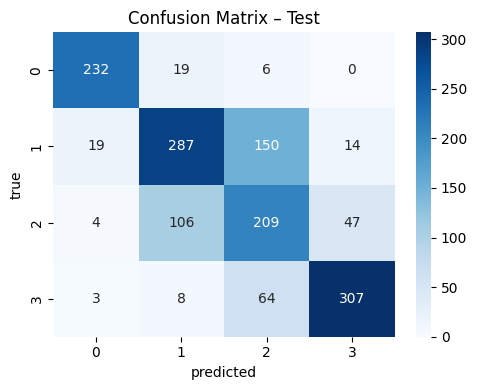

Матрица ошибок сохранена в confusion_matrix.png
Лог метрик накоплен в eval_log.jsonl


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 6) Оценка модели + дополнительные метрики
#    • Accuracy, Balanced Accuracy, Macro-F1, Macro-Precision, Macro-Recall
#    • ClassificationReport
#    • Матрица ошибок (PNG)
#    • Лог-файл с результатами
# ─────────────────────────────────────────────────────────────────────────────
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns, json
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             f1_score, precision_score, recall_score,
                             classification_report, confusion_matrix)
from pathlib import Path

# ░░ Пути ░░───────────────────────────────────────────────────────────────────
best_ckpt_path = Path('checkpoints') / 'best_resnet50_age.pth'
eval_log_path  = 'eval_log.jsonl'          # построчный JSON-лог

# ░░ 1. Загрузка лучших весов ░░──────────────────────────────────────────────
model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
model.eval(); torch.set_grad_enabled(False)
print('✅ Веса загружены из', best_ckpt_path)

# helper: получить true/pred списки ------------------------------------------
def get_preds(loader):
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        preds  = logits.argmax(1).cpu().numpy()
        y_true.extend(y.numpy()); y_pred.extend(preds)
    return np.array(y_true), np.array(y_pred)

# функция вывода и логирования ----------------------------------------------
def evaluate_split(name, loader):
    y, p = get_preds(loader)

    acc   = accuracy_score(y, p)
    bacc  = balanced_accuracy_score(y, p)
    mf1   = f1_score(y, p, average='macro')
    mprec = precision_score(y, p, average='macro', zero_division=0)
    mrec  = recall_score(y, p, average='macro', zero_division=0)

    print(f'\n── {name} ──')
    print(f'Accuracy          : {acc:.3f}')
    print(f'Balanced Accuracy : {bacc:.3f}')
    print(f'Macro-Precision   : {mprec:.3f}')
    print(f'Macro-Recall      : {mrec:.3f}')
    print(f'Macro-F1          : {mf1:.3f}')
    print(classification_report(y, p, digits=3))

    # запись в лог-файл
    with open(eval_log_path, 'a') as f:
        f.write(json.dumps({"split": name,
                            "accuracy": acc,
                            "balanced_accuracy": bacc,
                            "macro_precision": mprec,
                            "macro_recall": mrec,
                            "macro_f1": mf1}) + '\n')
    return y, p

# ░░ 2. Валидaция ░░──────────────────────────────────────────────────────────
y_val, p_val = evaluate_split('VAL', val_loader)

# ░░ 3. Тест ░░───────────────────────────────────────────────────────────────
y_test, p_test = evaluate_split('TEST', test_loader)

# ░░ 4. Матрица ошибок (по test) ░░────────────────────────────────────────────
cm = confusion_matrix(y_test, p_test, labels=[0, 1, 2, 3])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('predicted'); plt.ylabel('true'); plt.title('Confusion Matrix – Test')
plt.tight_layout(); plt.savefig('confusion_matrix.png', dpi=120); plt.show()
print('Матрица ошибок сохранена в confusion_matrix.png')
print('Лог метрик накоплен в', eval_log_path)


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Инференс для одиночного файла images\image_1.png
# ─────────────────────────────────────────────────────────────────────────────
from PIL import Image
import torch

img_path = Path(r"samples\image_1.png")        # ← ваш путь

# 1. Загружаем «лучшие» веса (если модель уже в памяти – пропустите)
best_ckpt = Path("checkpoints") / "best_resnet50_age.pth"
model.load_state_dict(torch.load(best_ckpt, map_location=device))
model.eval(); torch.set_grad_enabled(False)

# 2. Применяем те же val-трансформации
img = Image.open(img_path).convert("RGB")
tensor = val_transforms(img).unsqueeze(0).to(device)   # shape [1,3,224,224]

# 3. Предсказание
logits = model(tensor)
pred_class = logits.argmax(1).item()   # 0,1,2,3

print(f"{img_path}  →  предсказанный класс возраста: {pred_class}")


samples\image_1.png  →  предсказанный класс возраста: 0
